In [5]:
# Importing the libraries
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from sklearn.metrics.pairwise import cosine_similarity
from plotnine import *

main_data_path = 'main_dataset.pkl'
tmp_data_path = 'tmp_dataset.pkl'
dir_path = './3DMolMS-with-ornl/check_point'
check_point_paths = ['Medium']#['CosSim', 'Medium', 'Medium_from_start']
# Best ref model
best_ref_model = 'Medium'

def compute_r_squared(group):
    y_true = group['y']
    y_pred = group['pred']
    r2score = r2_score(y_true, y_pred)
    group['R2'] = r2score
    return group

# Compute cosine similarity
def compute_cosine_similarity(group):
    y_true = group['y']
    y_pred = group['pred']
    # Pairwise multiply the two vectors
    y_prod = np.multiply(y_true, y_pred)
    # Compute the norm of the two vectors
    y_true_norm = np.linalg.norm(y_true)
    y_pred_norm = np.linalg.norm(y_pred)
    cosine_similarity = np.sum(y_prod)/(y_true_norm*y_pred_norm)

    group['cosine_sim'] = cosine_similarity
    return group

#If file data_validation exists, load it
if os.path.isfile(tmp_data_path):
    df = pd.read_pickle(tmp_data_path)
else:    
    data_from_model_path = os.path.join(dir_path, best_ref_model)
    data_from_model_path = os.path.join(data_from_model_path, 'predictions')
    data_from_model_path = os.path.join(data_from_model_path, 'train')
    
    file_path = 'pred.csv'
    file_path = os.path.join(data_from_model_path, file_path)
    df_pred = pd.read_csv(file_path)

    file_path = 'pred_small.csv'
    file_path = os.path.join(data_from_model_path, file_path)
    df_pred_small = pd.read_csv(file_path)

    # Combine the two dataframes
    df_pred = pd.concat([df_pred, df_pred_small], ignore_index=True)
    # Add varaiable called dataset with value train
    df_pred['dataset'] = 'train'
    
    # Importing the dataset
    for i, check_point_path in enumerate(check_point_paths):
        data_from_model_path = os.path.join(dir_path, check_point_path)
        data_from_model_path = os.path.join(data_from_model_path, 'predictions')
        data_from_model_path = os.path.join(data_from_model_path, 'validation')
        file_path = 'pred.csv'
        file_path = os.path.join(data_from_model_path, file_path)        
        # Read file if it exists
        if os.path.isfile(file_path):
            df_tmp = pd.read_csv(file_path)

            file_path = 'pred_small.csv'
            file_path = os.path.join(data_from_model_path, file_path)
            assert os.path.isfile(file_path)
            df_tmp_small = pd.read_csv(file_path)

            # Combine the two dataframes
            df_tmp = pd.concat([df_tmp, df_tmp_small], ignore_index=True)
            df_tmp['dataset'] = 'validation' + '_' + str(i)
            df_pred = pd.concat([df_pred, df_tmp], ignore_index=True)

    # Save the dataframe
    df_pred = df_pred.sort_values(by=['model', 'smiles', 'nm'])
    df_pred = df_pred.reset_index(drop=True)
    # Group by model and smiles and normalize the pred by the max value
    df_pred['pred'] = df_pred.groupby(['model', 'smiles'])['pred'].transform(lambda x: x/x.max())
    df_pred['y'] = df_pred.groupby(['model', 'smiles'])['y'].transform(lambda x: x/x.max())
    df_pred.to_pickle(tmp_data_path)
    
    df = df_pred.copy()


In [10]:
data_attentive_fp_path = './AttentiveFP_data'
models = ['AttentiveFP_CS', 'AttentiveFP_CS_rep', 'AttentiveFP_MSE', 'AttentiveFP_MSE_rep']
# List files in dir data_attentive_fp_path
files = os.listdir(data_attentive_fp_path)
dfs = [] 
# Load tmp_data_path
df_pred = pd.read_pickle(tmp_data_path)
# Put all unique smiles from dataset = validation in a list
#smiles_vec_val = df[df['dataset'] == 'validation']['smiles'].unique()
smiles_vec_train = df[df['dataset'] == 'train']['smiles'].unique()


nm_vec = df_pred['nm'].unique()
for file in files:
    if 'train' in file:
        continue
    file_path = os.path.join(data_attentive_fp_path, file)
    # Print current jobb
    print("Currently processing: ", file_path)
    df_attentive_fp = pd.read_csv(file_path)
    # Set values below 0 to 0
    df_attentive_fp.iloc[:,1:] = df_attentive_fp.iloc[:,1:].apply(lambda x: np.where(x < 0, 0, x))

    # Square all numerical values in df_attentive_fp, column 1 to end
    df_attentive_fp.iloc[:,1:] = df_attentive_fp.iloc[:,1:].apply(lambda x: np.sqrt(x))

    # Normalize the values in df_attentive_fp, column 1 to end
    df_attentive_fp.iloc[:,1:] = df_attentive_fp.iloc[:,1:].apply(lambda x: x/x.max())
    
    # Set variable name on column 0 to 'smiles'
    df_attentive_fp = df_attentive_fp.rename(columns={df_attentive_fp.columns[0]: 'smiles'})
    df_attentive_fp = df_attentive_fp.sort_values(by=['smiles'])


    # Flip df_attentive_fp so smiles are variables and index 1 to end are values
    df_attentive_fp = df_attentive_fp.set_index('smiles').T
    # If file contains 'train' in the name, read it
    if 'train' in file:
        continue
    
        df_tmp = df_pred[df_pred['dataset'] == 'train'][['smiles', 'title']].drop_duplicates()
        # Chage varaible names in df_attentive_fp to smiles

        df_attentive_fp.columns = smiles_vec_train
        if 'MSE' in file:
            model = models[3]
        else:
            model = models[1]
    else:
        df_tmp = df_pred[df_pred['dataset'] == 'validation_0'][['smiles', 'title']].drop_duplicates()
        if 'MSE' in file:
            model = models[2]
        else:
            model = models[0]
    print(model)
    df_res = pd.DataFrame()
    df_list = []
    for idx, (_,pair) in enumerate(df_tmp.iterrows()):
        # Get the smiles and title
        smiles = pair['smiles']
        title = pair['title']
        
        # Print the shape of df_attentive_fp
        spectra = df_attentive_fp[smiles]
        # Pad the spectra to 171 with the last value in the spectra
        spectra = np.pad(spectra, (0, 1), 'constant', constant_values=(spectra.iloc[0], spectra.iloc[-1]))
        true_spectra = df_pred[(df_pred['smiles'] == smiles) & (df_pred['title'] == title) & (df_pred['dataset'] == 'validation_0')]['y'].values
        df_tmp2 = pd.DataFrame()
        df_tmp2['nm'] = nm_vec
        df_tmp2['pred'] = spectra
        df_tmp2['y'] = true_spectra
        # Add model, title and smiles to df_tmp2
        df_tmp2['model'] = model
        df_tmp2['title'] = title
        df_tmp2['smiles'] = smiles
        df_tmp2['group_id'] = model + '_' + smiles
        df_tmp2['dataset'] = 'validation'
        # Shuffle the varaiable order to match the order in df_pred
        df_tmp2 = df_tmp2[['model', 'title', 'smiles', 'nm', 'pred', 'y', 'group_id', 'dataset']]
        df_tmp2 = df_tmp2.reset_index(drop=True)
        df_list.append(df_tmp2)
        #df_res = df_res.reset_index(drop=True)
        #df_res = pd.concat([df_res, df_tmp2])

    # Concat the list of dataframes and df_pred
    df_res = pd.concat(df_list, ignore_index=True)
    df_res = df_res.reset_index(drop=True)
    df_res = df_res.sort_values(by=['model', 'smiles', 'nm'])
    df_res = df_res.reset_index(drop=True)
    dfs.append(df_res)
    
df_res = pd.concat(dfs, ignore_index=True)
df_res = df_res.reset_index(drop=True)
df_res = df_res.sort_values(by=['model', 'smiles', 'nm'])
df_res = df_res.reset_index(drop=True)

df_pred = df_pred.reset_index(drop=True)
df_pred = df_pred.sort_values(by=['model', 'smiles', 'nm'])
df_pred = df_pred.reset_index(drop=True)

# Sort df_pred by model, smiles, nm
df_pred = pd.concat([df_pred, df_res])

# Grouped by model and smiles and put the MAE, R2 and add variables to df_pred
df_pred['abs_error'] = np.abs(df_pred['y'] - df_pred['pred'])
# Grouped by pairs of model and smiles comopute the mean of abs_error
df_MAE = df_pred.groupby(['group_id'])['abs_error'].mean()
# Add the MAE to df_pred and match the model and smiles
df_pred = df_pred.merge(df_MAE, on=['group_id'])
# Rename the column to MAE and drop the abs_error column
df_pred = df_pred.rename(columns={'abs_error_x': 'abs_error', 'abs_error_y': 'MAE'})
df_pred = df_pred.drop(columns=['abs_error'])

# Apply the function to each group
df_R2 = df_pred.groupby(['group_id']).apply(compute_r_squared)

# df_R2 reindex
df_R2 = df_R2.reset_index(drop=True)
# Set values in pred and y below 1e-10 to 0
threshold = 1e-4
df_R2.loc[df_R2['pred'] < threshold, 'pred'] = 0
df_R2.loc[df_R2['y'] < threshold, 'y'] = 0

# Apply the function to each group
df_cosine_sim = df_R2.groupby(['model', 'smiles']).apply(compute_cosine_similarity)

df_cosine_sim = pd.concat([df_cosine_sim, df_pred_rep], ignore_index=True) 

df = df_cosine_sim.copy()

df.to_pickle(main_data_path)

Currently processing:  ./AttentiveFP_data/data_attentiveFP_val_MSE.csv
AttentiveFP_MSE
Currently processing:  ./AttentiveFP_data/data_attentiveFP_val_cosine.csv
AttentiveFP_CS


KeyboardInterrupt: 

/home/nyrenw/anaconda3/envs/MVE080/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_ydensity : Removed 9701 rows containing non-finite values.
/home/nyrenw/anaconda3/envs/MVE080/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 16375 rows containing missing values.


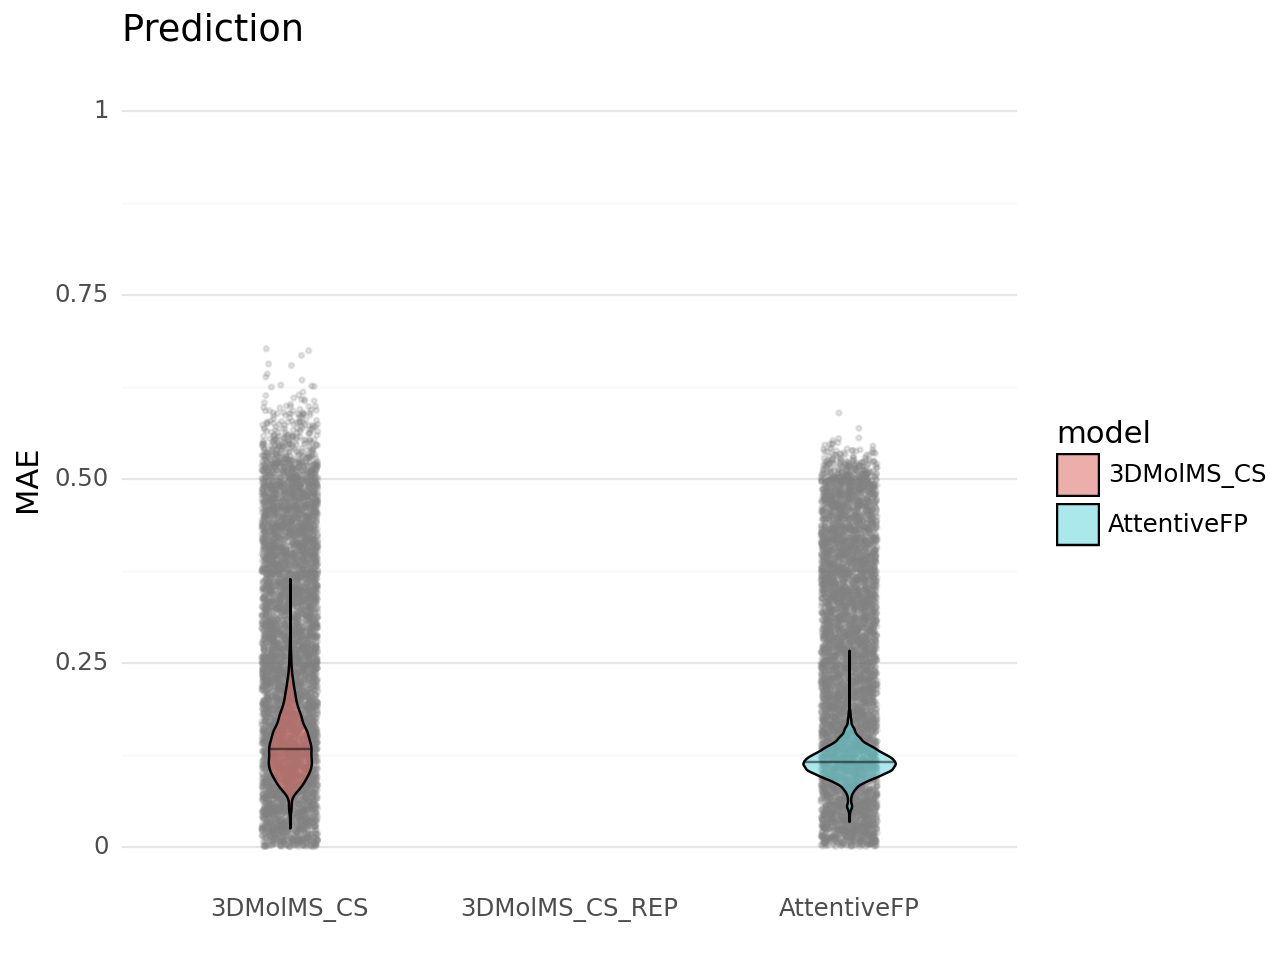

<Figure Size: (640 x 480)>

In [4]:

# Drop duplicates based on 'model_smiles'
df_unique = df.drop_duplicates(subset='model_smiles')

# Now proceed with your existing code but use df_unique instead of df
p = (ggplot(df_unique, aes('model', 'MAE', fill='model'))
    + geom_jitter(df_unique, aes(group='model_smiles'), width=0.1, size=0.5, alpha=0.2, color='grey', fill=None)
    + geom_violin(width=0.33, draw_quantiles=[0.5], alpha=0.5, color='black')
    + labs(y = 'MAE', x = '', title='Prediction ')
    # Set vertical scale fraom 0 to 1
    + ylim(0, 1)
    + theme_minimal()
    # Remove vertical grid lines
    + theme(panel_grid_major_x=element_blank())
)
p